In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/MINTS')

import numpy as np
import matplotlib.pyplot as plt
from MINTS import *


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## MINTS for dynamic pricing with Bernoulli demand model and Lipschitz constraint on the demand function

# configuration
prices = np.array([0.3, 0.4, 0.5, 0.6, 0.7]) # list of prices
demand_model = 'Bernoulli' # demand model
Lipschitz_const = 1 # Lipschitz constant for the constraint
T = 3000 # number of rounds
seed = 2025 # random seed


In [3]:
## initialization
rng = np.random.default_rng(seed) # set random seed
V = rng.random(T) # generate latent valuations
K = len(prices) # number of prices
posterior = np.ones((T + 1, K)) / K # record posterior distributions
seed_new = seed * 2 # use a different random seed to ensure independence between the randomness in the algorithm and the environment

# MINTS
mints = MINTS_dynamic_pricing(prices = prices, prior = None, demand_model = demand_model, Lipschitz_const = Lipschitz_const, seed = seed_new)

# Thompson Sampling (for comparison)
# model the revenue distribution corresponding to each price as a normal distribution with standard deviation 0.5
ts = TS(K = K, reward_model = 'Gaussian', reward_std = 0.5, seed = seed_new)


## online experiment
for t in range(T):
    # MINTS
    idx = mints.sample_decision() # sample a price index
    demand = int(V[t] >= prices[idx]) # observe the demand
    mints.update_belief(feedback = demand) # update the belief
    posterior[t + 1] = mints.posterior # record the posterior

    # Thompson Sampling
    idx = ts.sample_decision() # sample a price index
    price = prices[idx]
    demand = int(V[t] >= price) # observe the demand
    ts.update_belief(feedback = price * demand) # update the belief. The feedback is the reward (revenue) rather than the demand.






/usr/local/lib/python3.12/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


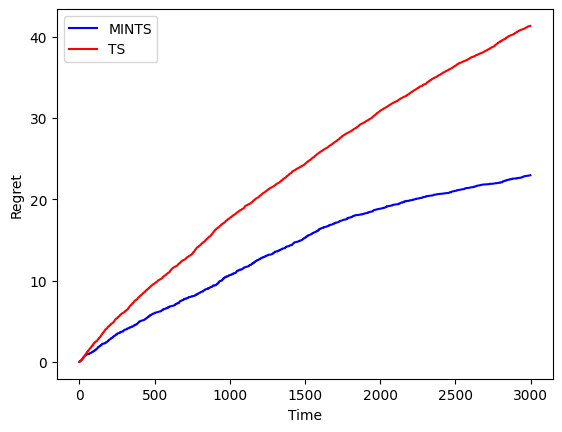

In [4]:
## Plot the regret curves

# define a function to compute the expected revenue given a price
def expected_revenue(price):
    return price * (1 - price)

R_max = np.max( expected_revenue(prices) ) # maximum expected revenue
R_MINTS = np.zeros(T) # record the expected revenue for each round (MINTS)
R_TS = np.zeros(T) # record the expected revenue for each round (TS)

for t in range(T):
    R_MINTS[t] = R_max - expected_revenue( prices[mints.decisions[t]] ) # MINTS
    R_TS[t] = R_max - expected_revenue( prices[ts.decisions[t]] ) # TS

regret_MINTS = np.cumsum(R_MINTS)
regret_TS = np.cumsum(R_TS)

plt.plot(regret_MINTS, 'b')
plt.plot(regret_TS, 'r')
plt.legend(['MINTS', 'TS'])
plt.xlabel('Time')
plt.ylabel('Regret')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MINTS/regrets.png')



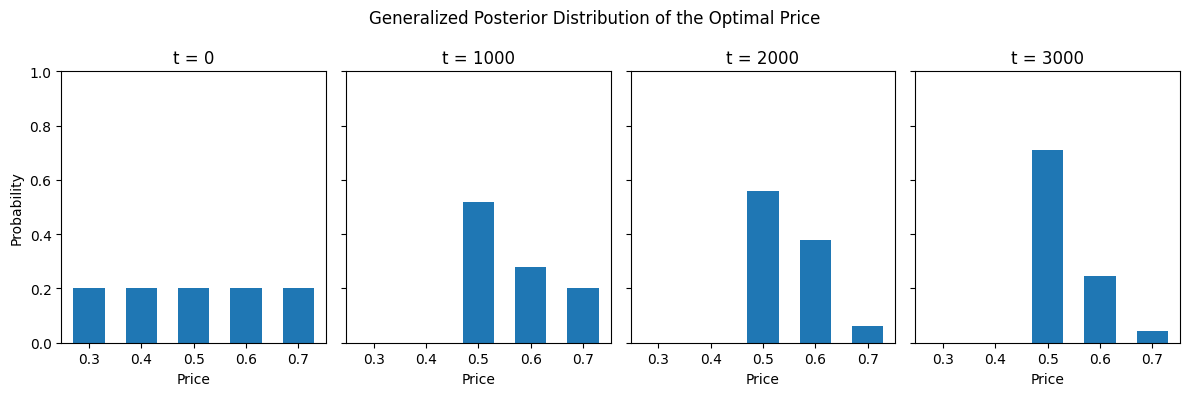

In [5]:
# Plot the posterior at specific times

snapshot_times = [0, T//3, 2*T//3, T]

fig, axes = plt.subplots(1, len(snapshot_times), figsize=(12, 4), sharey=True)
indices = range(K)

for i, t in enumerate(snapshot_times):
    # Use L for x-axis positions and labels
    axes[i].bar(indices, posterior[t, :], width=0.6)
    axes[i].set_xlabel('Price')
    axes[i].set_xticks(indices)
    axes[i].set_xticklabels(prices)
    axes[i].set_ylim(0, 1)
    axes[i].set_title(f't = {t}')
    if i == 0:
        axes[i].set_ylabel('Probability')

plt.suptitle('Generalized Posterior Distribution of the Optimal Price')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MINTS/posterior_snapshots.png', dpi=150)
plt.show()
